In [1]:
import pandas as pd

# Define URLs with proper encoding

# Load the datasets
train_df = pd.read_csv("data/train_nyc_311.csv", parse_dates=['Created Date'], low_memory=False)
test_df = pd.read_csv("data/test_nyc_311.csv", parse_dates=['Created Date'], low_memory=False)

# Quick checks
print("✅ Train rows:", train_df.shape[0])
print("✅ Test rows:", test_df.shape[0])

# Optional: Check the date range
print("📅 Train date range:", train_df['Created Date'].min(), "→", train_df['Created Date'].max())
print("📅 Test date range:", test_df['Created Date'].min(), "→", test_df['Created Date'].max())


/tmp/ipykernel_401/1232230017.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df = pd.read_csv("data/train_nyc_311.csv", parse_dates=['Created Date'], low_memory=False)
/tmp/ipykernel_401/1232230017.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_df = pd.read_csv("data/test_nyc_311.csv", parse_dates=['Created Date'], low_memory=False)


✅ Train rows: 2513997
✅ Test rows: 786859
📅 Train date range: 2024-08-01 00:00:02 → 2025-06-04 13:59:00
📅 Test date range: 2025-05-01 00:00:02 → 2025-07-31 23:52:43


In [2]:
def normalize_column_names(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace(r"[^\w_]", "", regex=True)  # optional: remove punctuation
    )
    return df

In [3]:
import pandas as pd
import numpy as np
import holidays

def prepare_daily_features(df, country_holidays):
    df = normalize_column_names(df)
    df['date'] = df['created_date'].dt.date
    daily = df.groupby('date').size().reset_index(name='total_calls')
    daily['date'] = pd.to_datetime(daily['date'])

    # Features
    daily['dayofweek'] = daily['date'].dt.dayofweek
    daily['month'] = daily['date'].dt.month
    daily['is_weekend'] = daily['dayofweek'] >= 5
    daily['is_holiday'] = daily['date'].isin(country_holidays)

    # Lag & Rolling
    daily['lag1'] = daily['total_calls'].shift(1)
    daily['rolling7_mean'] = daily['total_calls'].rolling(7).mean()
    daily['rolling7_std'] = daily['total_calls'].rolling(7).std()

    return daily.dropna()


In [4]:
us_holidays = holidays.US(state='NY', years=[2024, 2025])
daily_train = prepare_daily_features(train_df, us_holidays)
daily_test = prepare_daily_features(test_df, us_holidays)


/tmp/ipykernel_401/674027278.py:15: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  daily['is_holiday'] = daily['date'].isin(country_holidays)
/tmp/ipykernel_401/674027278.py:15: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  daily['is_holiday'] = daily['date'].isin(country_holidays)


In [5]:
daily_train

,date,total_calls,dayofweek,month,is_weekend,is_holiday,lag1,rolling7_mean,rolling7_std
6,2024-08-07,8672,2,8,False,False,9494.0,8803.857143,917.993542
7,2024-08-08,8192,3,8,False,False,8672.0,8706.857143,945.187006
8,2024-08-09,9790,4,8,False,False,8192.0,8860.857143,1030.164296
9,2024-08-10,8587,5,8,True,False,9790.0,8999.857143,889.993339
10,2024-08-11,9466,6,8,True,False,8587.0,9220.142857,760.774699
...,...,...,...,...,...,...,...,...,...
273,2025-05-01,2,3,5,False,False,9.0,4640.857143,3323.694953
274,2025-05-08,1,3,5,False,False,2.0,3529.571429,3398.800124
275,2025-05-09,1,4,5,False,False,1.0,2562.285714,3283.774135
276,2025-05-12,1,0,5,False,False,1.0,1588.714286,2784.787407


In [6]:
daily_test

,date,total_calls,dayofweek,month,is_weekend,is_holiday,lag1,rolling7_mean,rolling7_std
6,2025-05-07,9448,2,5,False,False,8731.0,8963.714286,600.559660
7,2025-05-08,9507,3,5,False,False,9448.0,9000.000000,627.997877
8,2025-05-09,8187,4,5,False,False,9507.0,8777.000000,594.369414
9,2025-05-10,9629,5,5,True,False,8187.0,8858.714286,673.351497
10,2025-05-11,10141,6,5,True,False,9629.0,9168.857143,695.405979
...,...,...,...,...,...,...,...,...,...
87,2025-07-27,8304,6,7,True,False,8138.0,7669.000000,402.089542
88,2025-07-28,7567,0,7,False,False,8304.0,7661.857143,403.608485
89,2025-07-29,7152,1,7,False,False,7567.0,7607.857143,447.130640
90,2025-07-30,6329,2,7,False,False,7152.0,7481.000000,654.422392


In [7]:
daily_train.isna().sum()

date             0
total_calls      0
dayofweek        0
month            0
is_weekend       0
is_holiday       0
lag1             0
rolling7_mean    0
rolling7_std     0
dtype: int64

In [8]:
daily_test.isna().sum()

date             0
total_calls      0
dayofweek        0
month            0
is_weekend       0
is_holiday       0
lag1             0
rolling7_mean    0
rolling7_std     0
dtype: int64

In [9]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from xgboost import XGBRegressor
"""model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
"""
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
"""
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)"""

#model = LGBMRegressor(n_estimators=100, random_state=42)

X_train = daily_train[['dayofweek', 'month', 'is_weekend', 'is_holiday', 'lag1', 'rolling7_mean', 'rolling7_std']]
y_train = daily_train['total_calls']

model.fit(X_train,y_train)

X_test = daily_test[['dayofweek', 'month', 'is_weekend', 'is_holiday', 'lag1', 'rolling7_mean', 'rolling7_std']]
preds = model.predict(X_test)


mse = mean_squared_error(daily_test['total_calls'], preds)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(daily_test['total_calls'], preds)

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAPE: {mape:.2%}")

submission_df = pd.DataFrame({
    'Date': daily_test['date'],
    'Predicted_Total_Calls': preds.round()
})
submission_df.to_csv("submission.csv", index=False)


Validation RMSE: 787.03
Validation MAPE: 7.70%


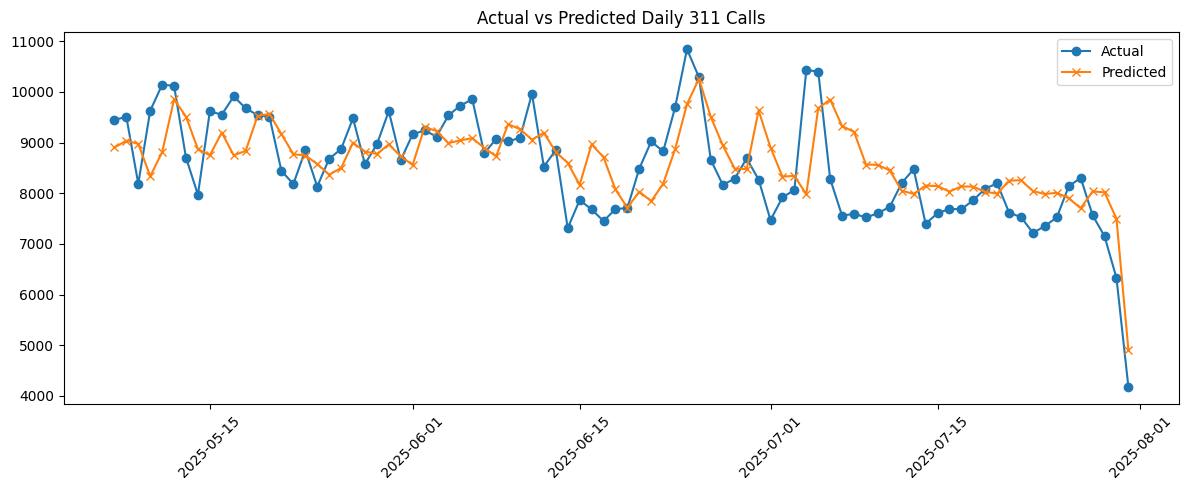

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(daily_test['date'], daily_test['total_calls'], label="Actual", marker='o')
plt.plot(daily_test['date'], preds, label="Predicted", marker='x')
plt.xticks(rotation=45)
plt.legend()
plt.title("Actual vs Predicted Daily 311 Calls")
plt.tight_layout()
plt.show()


In [11]:
# Compute anomaly score
daily_test['expected'] = preds
daily_test['actual'] = daily_test['total_calls']
daily_test['anomaly_score'] = ((daily_test['actual'] - daily_test['expected']) / daily_test['expected']) * 100

# Top 5 spikes & dips
top_spikes = daily_test.sort_values('anomaly_score', ascending=False).head(5)
top_dips = daily_test.sort_values('anomaly_score').head(5)

# Combine anomalies
anomalies_df = pd.concat([top_spikes, top_dips])[['date', 'actual', 'expected', 'anomaly_score']]
anomalies_df.columns = ['Date', 'Actual', 'Expected', 'Anomaly_Score']

# Add holiday note
anomalies_df['Note'] = anomalies_df['Date'].apply(
    lambda d: 'Holiday' if d in daily_test[daily_test['is_holiday'] == True]['date'].values else ''
)

# Save to CSV
anomalies_df.to_csv("anomalies.csv", index=False)


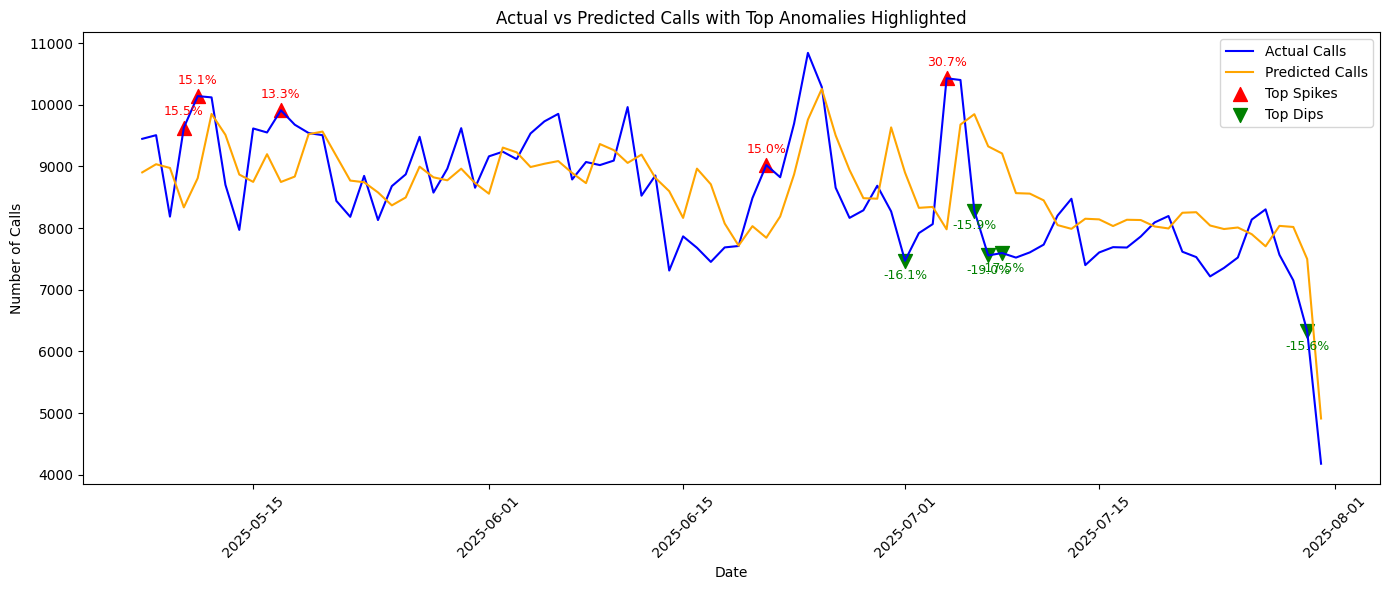

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot actual and predicted calls
plt.plot(daily_test['date'], daily_test['actual'], label='Actual Calls', color='blue')
plt.plot(daily_test['date'], daily_test['expected'], label='Predicted Calls', color='orange')

# Highlight top spikes
plt.scatter(top_spikes['date'], top_spikes['actual'], color='red', label='Top Spikes', s=100, marker='^')
for i, row in top_spikes.iterrows():
    plt.text(row['date'], row['actual']+200, f"{row['anomaly_score']:.1f}%", color='red', fontsize=9, ha='center')
# Highlight top dips
plt.scatter(top_dips['date'], top_dips['actual'], color='green', label='Top Dips', s=100, marker='v')
for i, row in top_dips.iterrows():
    plt.text(row['date'], row['actual']-300, f"{row['anomaly_score']:.1f}%", color='green', fontsize=9, ha='center')

plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.title('Actual vs Predicted Calls with Top Anomalies Highlighted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
daily_train.to_csv("dashboard/daily_features.csv", index=False)

In [23]:
import pandas as pd

# Load your full train_df
#train_df = pd.read_csv("data/train_nyc_311.csv", parse_dates=['Created Date'])

# Create 'date' column if not already there
train_df['date'] = train_df['created_date'].dt.date

# Select only required columns for the map
geo_df = train_df[['date', 'borough', 'latitude', 'longitude','complaint_type']].dropna()

# Ensure correct dtypes
geo_df['date'] = pd.to_datetime(geo_df['date'])
geo_df = geo_df[geo_df['latitude'].between(40.4, 41.0) & geo_df['longitude'].between(-74.3, -73.6)]  # remove bad GPS points

# Save for Streamlit
geo_df.to_csv("dashboard/geo_requests.csv", index=False)
